# Clustering HDBSCAN

In [12]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [8]:
dataset = pd.read_csv('../data/preprocessed_data.csv')
df = dataset.copy()

##### Preprocessing

In [9]:
df_processed = df.drop(columns=['pseudo_id'], errors='ignore')
df_processed = pd.get_dummies(df_processed, drop_first=True)
df_processed = df_processed.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed)

In [10]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=5)
labels = clusterer.fit_predict(X_scaled)
df['cluster'] = labels


c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
try:
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)
    df['pca1'] = components[:, 0]
    df['pca2'] = components[:, 1]
except Exception as e:
    print("No se pudo aplicar PCA 2D, creando columnas ficticias:", e)
    df['pca1'] = X_scaled[:, 0]
    df['pca2'] = np.zeros(X_scaled.shape[0])

C:\Users\xanet\AppData\Local\Temp\ipykernel_19836\1766102225.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


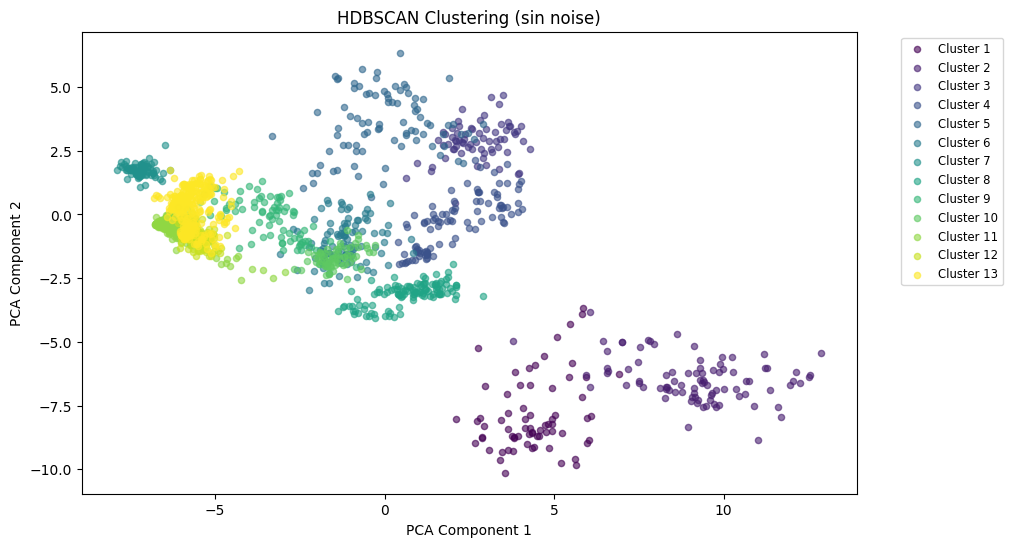

In [ ]:
plt.figure(figsize=(10, 6))

# Excluir noise (-1)
cluster_ids = [c for c in np.unique(df['cluster']) if c != -1]
n_clusters = len(cluster_ids)

if n_clusters == 0:
    print("No se encontraron clusters (todos son noise).")
else:
    cmap = plt.cm.get_cmap('viridis')
    denom = max(n_clusters - 1, 1)

    # Crear un diccionario que asigne un número consecutivo a cada cluster
    cluster_map = {orig_id: i+1 for i, orig_id in enumerate(sorted(cluster_ids))}

    for i, orig_cluster in enumerate(sorted(cluster_ids)):
        mask = df['cluster'] == orig_cluster
        color = cmap(i / denom)
        plt.scatter(df.loc[mask, 'pca1'], df.loc[mask, 'pca2'],
                    color=color, label=f'Cluster {cluster_map[orig_cluster]}', alpha=0.6, s=20)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('HDBSCAN Clustering (sin noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()

In [13]:
try:
    reducer = umap.UMAP(n_components=2,
                       n_neighbors=30,    # prueba 10, 15, 30, 50...
                       min_dist=0.1,      # prueba 0.0, 0.1, 0.5...
                       metric='euclidean',
                       random_state=42,
                       verbose=True)
    embedding = reducer.fit_transform(X_scaled)
    df['umap1'] = embedding[:, 0]
    df['umap2'] = embedding[:, 1]
except Exception as e:
    print("No se pudo aplicar UMAP 2D, creando columnas ficticias:", e)
    # Fallback: usa primeras dos columnas escaladas (peor opción)
    df['umap1'] = X_scaled[:, 0]
    df['umap2'] = X_scaled[:, 1]

c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Fri Dec 12 08:51:02 2025 Construct fuzzy simplicial set
Fri Dec 12 08:51:02 2025 Finding Nearest Neighbors
Fri Dec 12 08:51:02 2025 Building RP forest with 10 trees
Fri Dec 12 08:51:09 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Fri Dec 12 08:51:20 2025 Finished Nearest Neighbor Search
Fri Dec 12 08:51:23 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec 12 08:52:07 2025 Finished embedding


C:\Users\xanet\AppData\Local\Temp\ipykernel_4552\394498716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')  # buen mapa para varios clusters


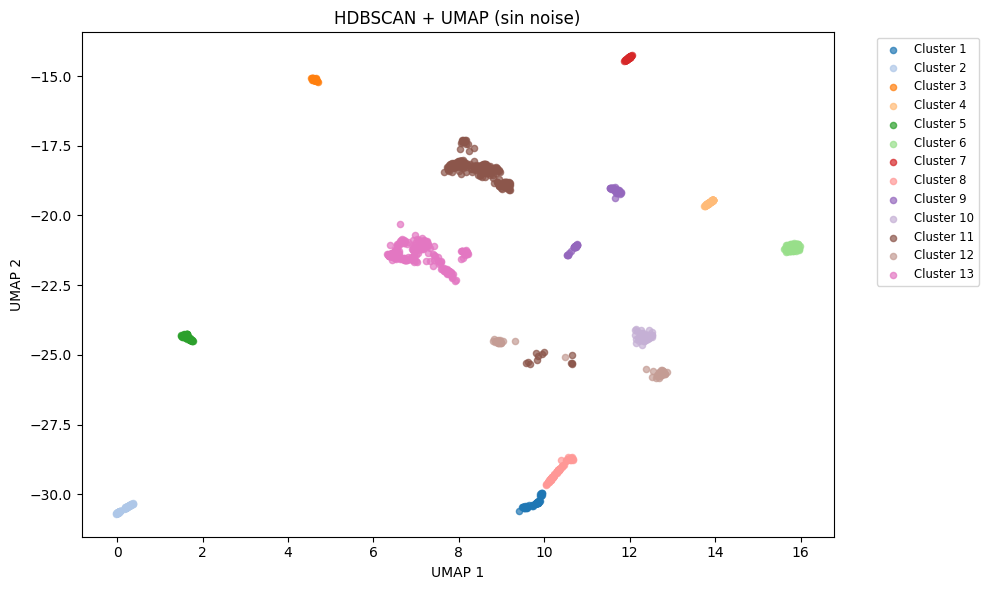

In [14]:
# --- Visualización con UMAP (sin noise) ---
plt.figure(figsize=(10, 6))

# Excluir noise (-1) si quieres (pero dejo opción de mostrarlo en gris)
show_noise = False  # cambia a True si prefieres ver el noise también

cluster_ids = [c for c in np.unique(df['cluster']) if (c != -1 or show_noise)]
# Si show_noise=True, incluimos -1 como cluster especial
if show_noise and (-1 in np.unique(df['cluster'])):
    cluster_ids = sorted(np.unique(df['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(df['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No se encontraron clusters (todos son noise).")
else:
    cmap = plt.cm.get_cmap('tab20')  # buen mapa para varios clusters
    # Mapa que asigna índices consecutivos a clusters distintos de -1
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = df['cluster'] == orig_cluster
        if orig_cluster == -1:
            # ruido en gris (o ignorarlo si show_noise=False)
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(df.loc[mask, 'umap1'], df.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('HDBSCAN + UMAP (sin noise)' if not show_noise else 'HDBSCAN + UMAP (incluye noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


In [16]:
# calcula columnas más representativas por cluster (z-score vs media global)
features = df_processed.columns
global_mean = df_processed.mean()
global_std = df_processed.std().replace(0, 1e-6)  # evitar divisiones por 0
top_n = 5  # cambia si quieres más/menos

top_per_cluster = {}

i = 0

for cluster in sorted([c for c in df['cluster'].unique() if c != -1]):
    # Definir máscara para este cluster
    mask = df['cluster'] == cluster
    
    cluster_mean = df_processed.loc[mask, features].mean()
    cluster_std  = df_processed.loc[mask, features].std().replace(0, 1e-6)

    z_diff = (cluster_mean - global_mean) / global_std
    pooled_std = np.sqrt((cluster_std**2 + global_std**2) / 2)
    cohen_d = (cluster_mean - global_mean) / pooled_std

    top = z_diff.abs().sort_values(ascending=False).head(top_n)
    i+=1
    results = pd.DataFrame({
        'cluster Num': i,
        'z_diff': z_diff[top.index],
        'cohen_d': cohen_d[top.index],
        'cluster_mean': cluster_mean[top.index],
        'global_mean': global_mean[top.index],
        'direction': ['higher in cluster' if z_diff[f] > 0 else 'lower in cluster' for f in top.index],
        'cluster_size': mask.sum()
    })
    display(results.style.format({'z_diff':'{:.2f}','cohen_d':'{:.2f}','cluster_mean':'{:.3f}','global_mean':'{:.3f}'}))
    
    top_per_cluster[cluster] = results

,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
yes__specify_comm_leader,1,-7.39,-3.86,0.493,1.971,lower in cluster,69
yes__specify_awaaz,1,-6.77,-9.57,0.000,1.957,lower in cluster,69
yes__specify_demining_org,1,-6.69,-4.26,0.348,1.965,lower in cluster,69
mines_report,1,6.33,8.95,2.000,0.053,higher in cluster,69
yes__specify_mapa,1,-6.32,-5.79,0.130,1.957,lower in cluster,69


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
hlp_problems_property_is_unla_1,2,5.54,3.82,0.911,0.026,higher in cluster,90
lacking_documenta_what_are_wh_4,2,5.35,2.65,0.811,0.022,higher in cluster,90
unablere_issu_whys_lackknowle,2,4.27,1.23,0.456,0.011,higher in cluster,90
hlp_problems_lootingproperty,2,4.09,3.44,0.911,0.047,higher in cluster,90
sending_boys_are_they_engag_d_1,2,3.93,5.07,0.989,0.060,higher in cluster,90


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
yeschildren_behaviour_withdrawn,3,3.85,4.45,0.971,0.060,higher in cluster,70
whypsychological_distress_con_1,3,3.56,4.20,0.971,0.069,higher in cluster,70
yes__specify_what_places_scho_1,3,-3.52,-3.08,0.100,0.939,lower in cluster,70
yesoths_behaviour_withdrawn,3,3.45,3.82,0.957,0.071,higher in cluster,70
yeschildren_behaviour_violent_1,3,3.06,3.01,0.914,0.081,higher in cluster,70


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
yes__specify_what_places_sani_1,4,5.55,7.84,1.000,0.031,higher in cluster,94
yes__specify_what_places_wate_1,4,3.26,4.61,1.000,0.086,higher in cluster,94
yes__specify_what_places_heal_1,4,3.07,4.34,1.000,0.096,higher in cluster,94
no_which_groups_disability,4,2.60,3.51,0.989,0.126,higher in cluster,94
male_60,4,2.59,3.10,0.957,0.119,higher in cluster,94


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
whypsychological_distress_den_2,5,4.45,4.70,0.965,0.045,higher in cluster,86
whypsychological_distress_den_1,5,3.71,4.18,0.965,0.063,higher in cluster,86
yesoths_behaviour_withdrawn,5,3.62,5.12,1.000,0.071,higher in cluster,86
yesoths_behaviour_violent_agg_1,5,2.95,3.71,0.977,0.099,higher in cluster,86
yeschildren_behaviour_withdrawn,5,2.70,1.74,0.698,0.060,higher in cluster,86


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
yesimpactoth,6,4.70,5.98,0.990,0.043,higher in cluster,105
yes_which_documentation_divor_1,6,2.33,3.30,1.000,0.155,higher in cluster,105
yes_which_documentation_death_1,6,2.26,3.08,0.990,0.161,higher in cluster,105
lacking_documenta_what_are_wh_1,6,-2.22,-2.44,0.086,0.859,lower in cluster,105
yesimpactunableaccess_basic_s_1,6,-2.17,-3.07,0.000,0.825,lower in cluster,105


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
intendinginte_what_are_whys_h_1,7,8.07,7.00,0.976,0.014,higher in cluster,84
intendinginte_what_are_whys_b_1,7,5.40,2.65,0.810,0.022,higher in cluster,84
displaced_vuln_migration,7,5.36,7.58,1.000,0.034,higher in cluster,84
intendinginte_what_are_whys_h_2,7,4.01,4.71,0.976,0.056,higher in cluster,84
intendinginte_what_are_whys_s_1,7,3.78,5.35,1.000,0.065,higher in cluster,84


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
why_002_oth,8,3.97,5.62,1.000,0.060,higher in cluster,114
lacking_documenta_what_are_wh_9,8,3.57,3.47,0.930,0.063,higher in cluster,114
lacking_documenta_what_are_wh_5,8,3.46,2.14,0.763,0.045,higher in cluster,114
yesimpactunableaccess_assistance,8,2.17,2.98,0.991,0.172,higher in cluster,114
yesimpactunableaccess_basic_s_1,8,-2.15,-2.95,0.009,0.825,lower in cluster,114


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
lacking_documenta_what_are_wh_3,9,3.79,2.20,0.765,0.038,higher in cluster,81
intendinginte_what_are_whys_c_1,9,3.30,1.46,0.568,0.028,higher in cluster,81
lacking_documenta_what_are_wh_2,9,2.87,2.12,0.790,0.068,higher in cluster,81
you_haveissue_you_goresolve_i_6,9,2.24,3.03,0.988,0.162,higher in cluster,81
intendinginte_what_are_whys_r_1,9,2.20,1.29,0.556,0.055,higher in cluster,81


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
whypsychological_distress_lac_1,10,2.06,2.55,0.956,0.175,higher in cluster,68
in_past_month_whichth_engagin_1,10,1.79,2.43,0.985,0.231,higher in cluster,68
province,10,1.63,2.31,30.000,14.384,higher in cluster,68
interview_province,10,1.55,2.19,29.000,14.651,higher in cluster,68
no_which_groups_001_girls,10,-1.51,-1.38,0.265,0.831,lower in cluster,68


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
you_haveissue_you_goresolve_i_4,11,2.62,3.31,0.973,0.121,higher in cluster,449
resolved,11,-2.43,-3.10,0.053,1.693,lower in cluster,449
interview_province,11,-1.53,-2.07,0.457,14.651,lower in cluster,449
psychological_support,11,1.52,2.13,2.996,1.661,higher in cluster,449
province,11,-1.46,-1.99,0.425,14.384,lower in cluster,449


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
assessment_modality,12,1.76,2.41,1.988,1.237,higher in cluster,81
you_haveissue_you_goresolve_i_4,12,1.67,1.34,0.667,0.121,higher in cluster,81
resolved,12,-1.52,-1.25,0.667,1.693,lower in cluster,81
are_you_headhh,12,-1.40,-1.75,1.062,1.702,lower in cluster,81
are_you_lacking_civil_document,12,-1.28,-1.82,1.000,1.623,lower in cluster,81


,cluster Num,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
why_002_socio_cultural_barrie_1,13,2.32,2.98,0.972,0.148,higher in cluster,362
no_which_groups_001_girls,13,-2.19,-2.98,0.011,0.831,lower in cluster,362
hlp_problems_rent_dispute,13,1.65,1.33,0.663,0.122,higher in cluster,362
no_which_groups_001_boys,13,-1.58,-2.24,0.000,0.715,lower in cluster,362
main_learning_topics_access,13,-1.53,-2.10,0.014,0.710,lower in cluster,362


In [20]:
top_n = 10  # número de columnas a mostrar inicialmente por cluster
important_keywords = [
    'mines', 'psychological', 'children', 'family', 'hh', 'access', 'health', 
    'disability', 'school', 'water', 'sani', 'food', 'legal'
]  # keywords que consideramos importantes para la asignación de refugios

features = df_processed.columns
global_mean = df_processed.mean()
global_std = df_processed.std().replace(0, 1e-6)

cluster_summary = {}

for cluster in sorted([c for c in df['cluster'].unique() if c != -1]):
    mask = df['cluster'] == cluster
    cluster_mean = df_processed.loc[mask, features].mean()
    cluster_std  = df_processed.loc[mask, features].std().replace(0, 1e-6)

    # z-score vs global
    z_diff = (cluster_mean - global_mean) / global_std
    pooled_std = np.sqrt((cluster_std**2 + global_std**2) / 2)
    cohen_d = (cluster_mean - global_mean) / pooled_std

    # Top variables por z_diff absoluto
    top_vars = z_diff.abs().sort_values(ascending=False).head(top_n).index.tolist()

    # Filtrar por palabras clave
    top_operational = [v for v in top_vars if any(k in v.lower() for k in important_keywords)]
    
    # Si ninguna columna clave aparece, agregar la top estadística
    if len(top_operational) == 0:
        top_operational = top_vars[:5]

    summary = pd.DataFrame({
        'variable': top_operational,
        'z_diff': z_diff[top_operational].values,
        'cohen_d': cohen_d[top_operational].values,
        'cluster_mean': cluster_mean[top_operational].values,
        'global_mean': global_mean[top_operational].values,
        'direction': ['higher in cluster' if z_diff[v] > 0 else 'lower in cluster' for v in top_operational],
        'cluster_size': mask.sum()
    })

    cluster_summary[cluster] = summary
    print(f"\n- Cluster {cluster+1}")
    display(summary.style.format({
        'z_diff':'{:.2f}',
        'cohen_d':'{:.2f}',
        'cluster_mean':'{:.3f}',
        'global_mean':'{:.3f}'
    }))

# cluster_summary ahora contiene un dataframe por cluster con variables clave



- Cluster 1


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,mines_report,6.33,8.95,2.000,0.053,higher in cluster,69
1,mines_yes_cant_agricult,3.73,1.17,0.435,0.013,higher in cluster,69



- Cluster 2


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,hh_info_002_legal_needs,3.28,2.17,0.778,0.052,higher in cluster,90



- Cluster 3


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,yeschildren_behaviour_withdrawn,3.85,4.45,0.971,0.060,higher in cluster,70
1,whypsychological_distress_con_1,3.56,4.20,0.971,0.069,higher in cluster,70
2,yeschildren_behaviour_violent_1,3.06,3.01,0.914,0.081,higher in cluster,70
3,whypsychological_distress_eco_1,-2.58,-3.44,0.014,0.873,lower in cluster,70



- Cluster 4


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,yes__specify_what_places_sani_1,5.55,7.84,1.000,0.031,higher in cluster,94
1,no_which_groups_disability,2.60,3.51,0.989,0.126,higher in cluster,94
2,no_which_groups_002_disability,2.35,3.08,0.979,0.146,higher in cluster,94



- Cluster 5


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,whypsychological_distress_den_2,4.45,4.70,0.965,0.045,higher in cluster,86
1,whypsychological_distress_den_1,3.71,4.18,0.965,0.063,higher in cluster,86
2,yeschildren_behaviour_withdrawn,2.70,1.74,0.698,0.060,higher in cluster,86
3,whypsychological_distress_out_1,2.61,3.35,0.977,0.122,higher in cluster,86
4,yeschildren_behaviour_violent_1,2.31,1.67,0.709,0.081,higher in cluster,86



- Cluster 6


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,yesimpactunableaccess_basic_s_1,-2.17,-3.07,0.000,0.825,lower in cluster,105



- Cluster 7


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,intendinginte_what_are_whys_h_1,8.07,7.00,0.976,0.014,higher in cluster,84
1,intendinginte_what_are_whys_b_1,5.40,2.65,0.810,0.022,higher in cluster,84
2,displaced_vuln_migration,5.36,7.58,1.000,0.034,higher in cluster,84
3,intendinginte_what_are_whys_h_2,4.01,4.71,0.976,0.056,higher in cluster,84
4,intendinginte_what_are_whys_s_1,3.78,5.35,1.000,0.065,higher in cluster,84



- Cluster 8


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,yesimpactunableaccess_assistance,2.17,2.98,0.991,0.172,higher in cluster,114
1,yesimpactunableaccess_basic_s_1,-2.15,-2.95,0.009,0.825,lower in cluster,114
2,yeschildren_behaviour_eating__1,2.00,1.55,0.702,0.100,higher in cluster,114
3,yeschildren_behaviour_stressed,1.98,1.72,0.772,0.123,higher in cluster,114
4,whypsychological_distress_lac_1,1.87,2.03,0.886,0.175,higher in cluster,114



- Cluster 9


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,lacking_documenta_what_are_wh_3,3.79,2.20,0.765,0.038,higher in cluster,81
1,intendinginte_what_are_whys_c_1,3.30,1.46,0.568,0.028,higher in cluster,81
2,lacking_documenta_what_are_wh_2,2.87,2.12,0.790,0.068,higher in cluster,81
3,you_haveissue_you_goresolve_i_6,2.24,3.03,0.988,0.162,higher in cluster,81
4,intendinginte_what_are_whys_r_1,2.20,1.29,0.556,0.055,higher in cluster,81



- Cluster 10


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,whypsychological_distress_lac_1,2.06,2.55,0.956,0.175,higher in cluster,68



- Cluster 11


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,psychological_support,1.52,2.13,2.996,1.661,higher in cluster,449
1,are_you_headhh,-1.29,-1.50,1.111,1.702,lower in cluster,449
2,hh_info_002_school_dropout,1.24,1.60,0.951,0.356,higher in cluster,449



- Cluster 12


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,are_you_headhh,-1.40,-1.75,1.062,1.702,lower in cluster,81
1,hh_info_002_none,1.17,1.66,1.000,0.421,higher in cluster,81
2,access_mhpss_facility_no_001,-1.17,-1.65,0.000,7.089,lower in cluster,81



- Cluster 13


,variable,z_diff,cohen_d,cluster_mean,global_mean,direction,cluster_size
0,main_learning_topics_access,-1.53,-2.10,0.014,0.710,lower in cluster,362


In [10]:
correlations = df.corr()['cluster'].sort_values(key=abs, ascending=False)
print(correlations)


cluster                            1.000000
pca1                              -0.486133
assessment_modality                0.415455
are_you_lacking_civil_document    -0.387531
are_you_experiencing_any_issu_8    0.379143
                                     ...   
lacking_documenta_what_are_wh_5    0.001695
why_002_oth                        0.000321
interviewtype                           NaN
intendingreturnmove_explosive_1         NaN
intendingreturnmove_explosive           NaN
Name: cluster, Length: 366, dtype: float64


c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\xanet\AppData\Local\Temp\ipykernel_19836\2349009873.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['microcluster'] = clusterer.fit_predict(df_scaled)
C:\Users\xanet\AppData\Local\Temp\ipykernel_19836\2349009873.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

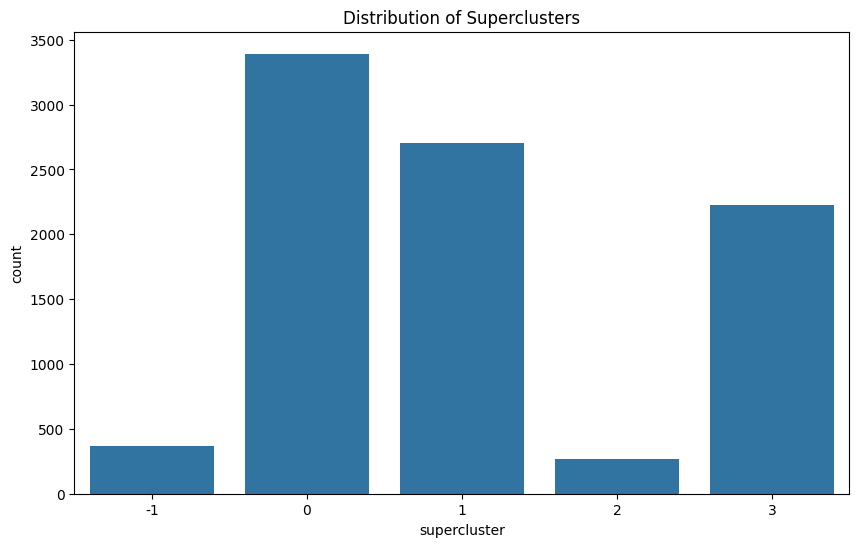

In [11]:
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Leer dataset
dataset = pd.read_csv('../data/preprocessed_data.csv')

# Columnas que quieres usar para clustering
columns_for_clustering = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60',
    'hh_info_person_health','hh_info_legal_needs','hh_info_school_dropout',
    'hh_info_unable_work','hh_info_child_armed_group','hh_info_family_unity',
    'hh_info_drug_dependence'
]

df_numeric = dataset[columns_for_clustering]

# Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# HDBSCAN microclusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=75, min_samples=5)
df_numeric['microcluster'] = clusterer.fit_predict(df_scaled)

# Excluir ruido
clustered_data = df_numeric[df_numeric['microcluster'] != -1]

# Calcular centroides de microclusters
centroids = clustered_data.groupby('microcluster').mean()

# Normalizar centroides
centroids_scaled = scaler.fit_transform(centroids)

# KMeans para superclusters
kmeans = KMeans(n_clusters=4, random_state=42)
supercluster_labels = kmeans.fit_predict(centroids_scaled)

# Mapping microcluster -> supercluster
micro_to_super = dict(zip(centroids.index, supercluster_labels))
df_numeric['supercluster'] = df_numeric['microcluster'].apply(
    lambda x: -1 if x == -1 else micro_to_super[x]
)

# Visualizar
plt.figure(figsize=(10,6))
sns.countplot(x='supercluster', data=df_numeric)
plt.title("Distribution of Superclusters")
plt.show()


c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\xanet\.conda\envs\ai25\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


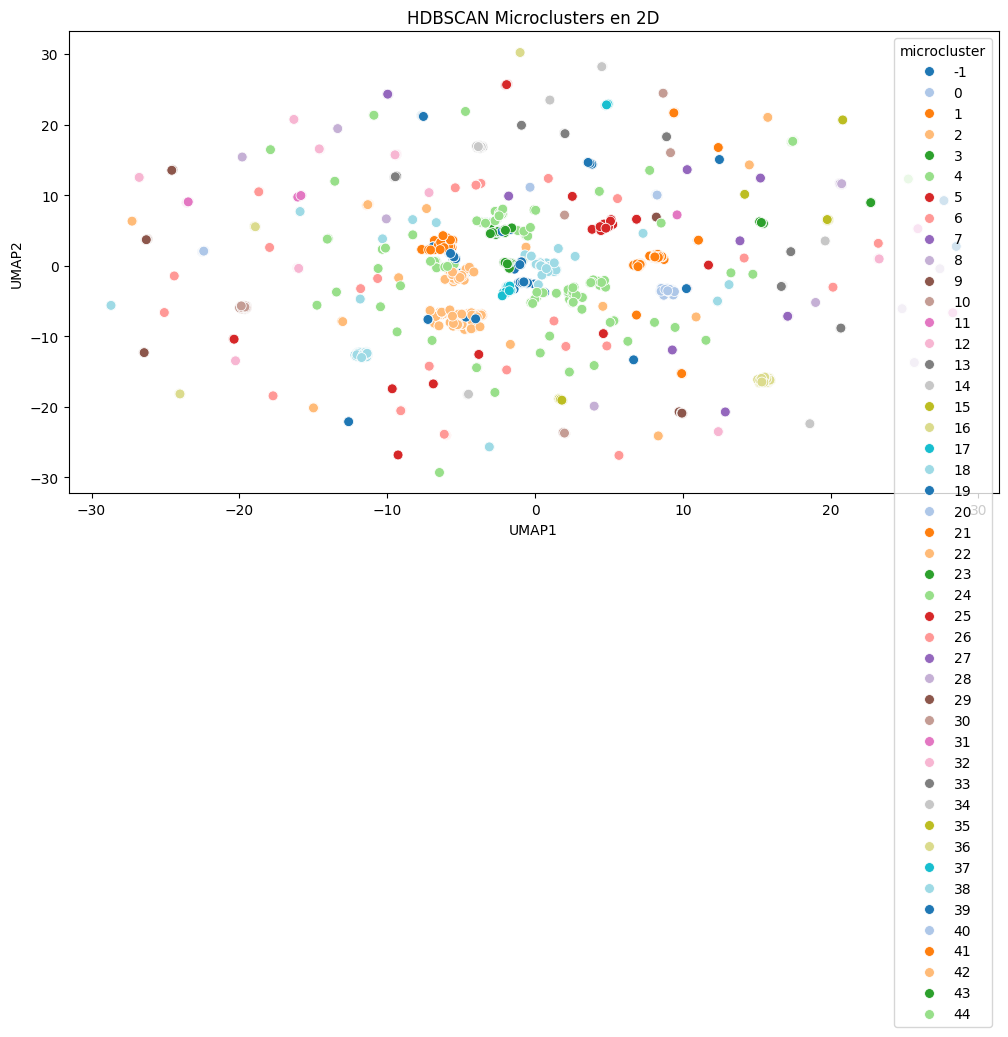

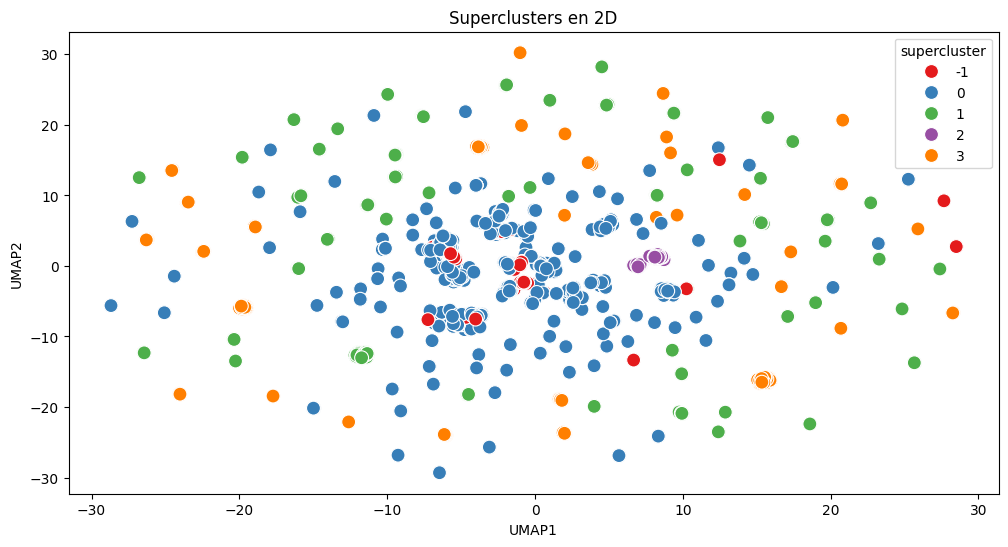

In [12]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 dimensiones usando UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(df_scaled)  # df_scaled es tu dataset numérico escalado

# Crear un DataFrame para plotear
plot_df = pd.DataFrame()
plot_df['UMAP1'] = embedding[:, 0]
plot_df['UMAP2'] = embedding[:, 1]
plot_df['microcluster'] = df_numeric['microcluster'].values
plot_df['supercluster'] = df_numeric['supercluster'].values

# Scatter plot para microclusters
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='microcluster',  # Cambia por 'supercluster' si quieres ver los grupos grandes
    palette='tab20',
    data=plot_df,
    legend='full',
    s=50
)
plt.title('HDBSCAN Microclusters en 2D')
plt.show()

# Scatter plot para superclusters
plt.figure(figsize=(12,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='supercluster',
    palette='Set1',
    data=plot_df,
    legend='full',
    s=100
)
plt.title('Superclusters en 2D')
plt.show()
